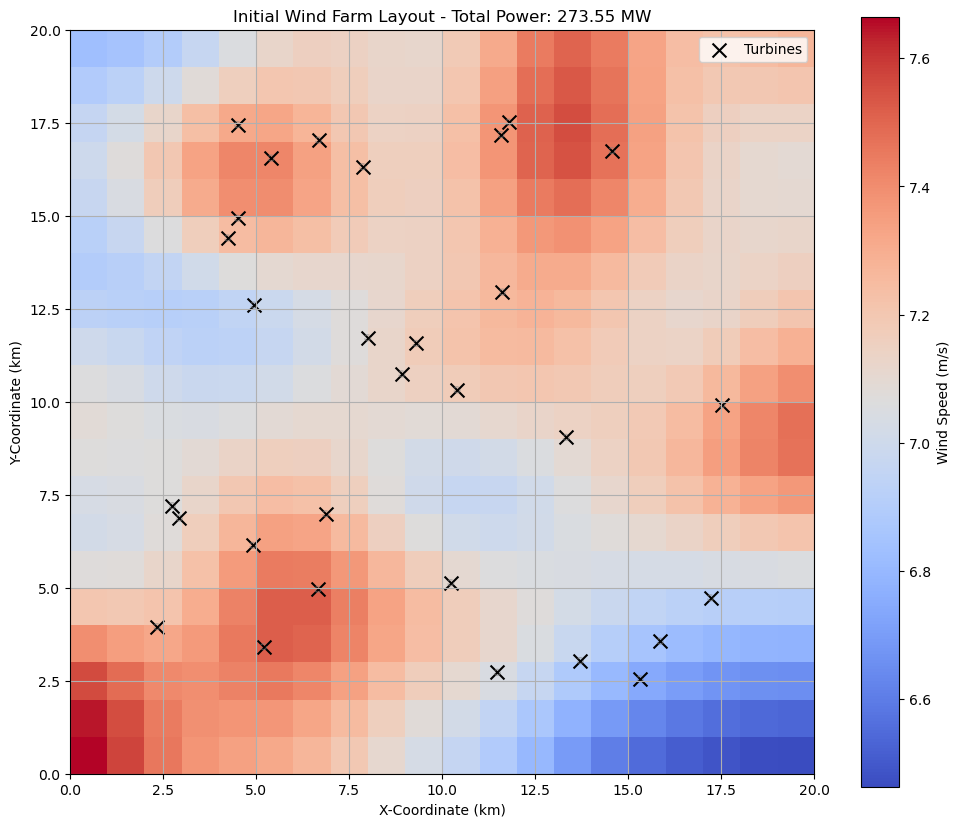

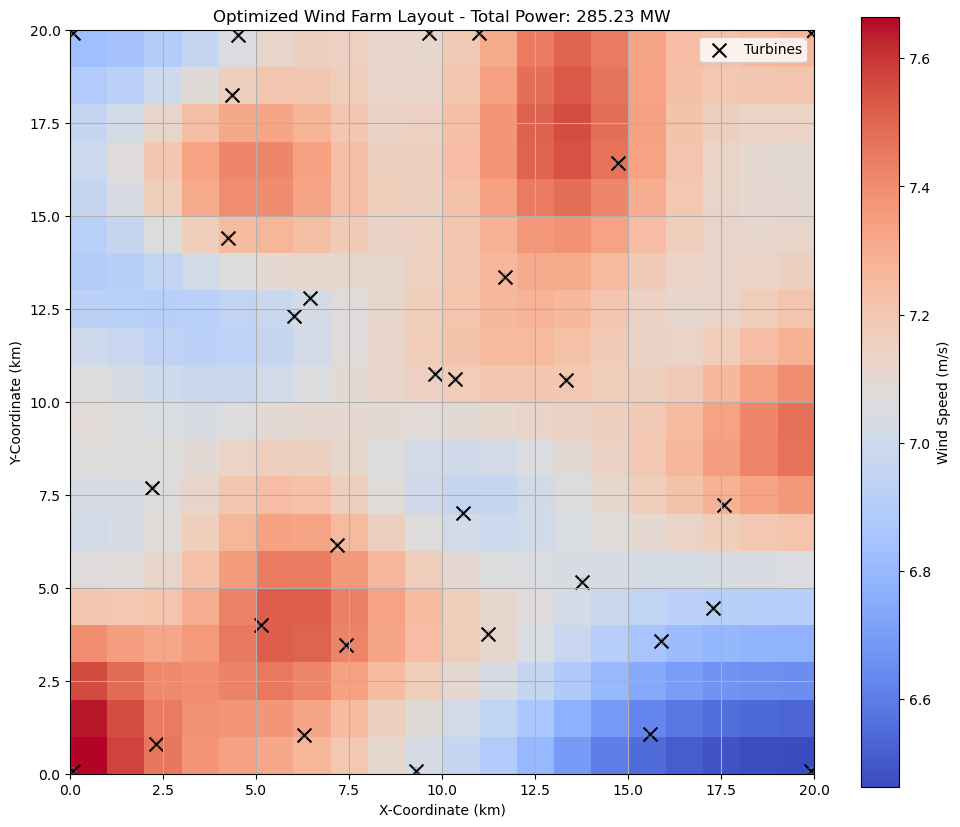

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def load_wind_data(csv_file='wind_map.csv'):
    """Load wind data from CSV file"""
    try:
        wind_data = np.loadtxt(csv_file, delimiter=',')
    except:
        wind_data = pd.read_csv(csv_file, header=None).values
    return wind_data

def turbine_power_curve(wind_speed):
    """Calculates power output based on wind speed."""
    if wind_speed < 4: 
        return 0  # Below cut-in speed, no power generated
    elif wind_speed < 12:
        return 0.5 * (wind_speed - 4)**2 # Partial power generated
    elif wind_speed < 25:
        return 40 + 1.2 * (wind_speed - 12)  # Full power generated
    else:
        return 0  # Cut-out speed reached, no power

def calculate_spacing_penalty(x, y, rotor_diameter=80):
    """Calculate penalty for violating minimum spacing constraints."""
    min_spacing = 5 * rotor_diameter
    num_turbines = len(x)
    penalty = 0

    for i in range(num_turbines):
        for j in range(i + 1, num_turbines):
            distance = np.sqrt((x[i] - x[j])**2 + (y[i] - y[j])**2)
            if distance < min_spacing:
                
                # Quadratic penalty for spacing violations
                penalty += 5 * ((min_spacing - distance) / min_spacing) ** 2

    return penalty

def wake_deficit(x_i, y_i, x_j, y_j, wind_direction, wind_speed, rotor_diameter=80):
    """Calculate wake deficit using Jensen wake model."""
    k = 0.075  # Wake decay constant
    Ct = 0.88  # Thrust coefficient

    # Convert wind direction to radians
    theta = np.radians(wind_direction)

    # Calculate distance between turbines
    dx = x_i - x_j
    dy = y_i - y_j
    distance = np.sqrt(dx**2 + dy**2)

    # Calculate wake radius at distance x
    wake_radius = rotor_diameter/2 + k * distance

    # Calculate relative position in wake
    crosswind_distance = abs(-np.sin(theta) * dx + np.cos(theta) * dy)

    if crosswind_distance > wake_radius or distance <= 0:
        return 0

    # Calculate velocity deficit
    deficit = (1 - np.sqrt(1 - Ct)) * (rotor_diameter/(2 * wake_radius))**2

    # Apply gaussian wake profile
    deficit *= np.exp(-0.5 * (crosswind_distance/wake_radius)**2)

    return deficit * wind_speed

def objective_function(x, y, wind_speed_map, turbine_power_curve, rotor_diameter=80):
    """Calculates the negative total power output with penalties."""
    num_turbines = len(x)
    total_power = 0
    spacing_penalty = calculate_spacing_penalty(x, y, rotor_diameter)

    # Dominant wind direction (could be made variable)
    wind_direction = 0  # degrees

    for i in range(num_turbines):
        y_i = min(max(int(y[i]), 0), wind_speed_map.shape[0]-1)
        x_i = min(max(int(x[i]), 0), wind_speed_map.shape[1]-1)

        # Get base wind speed
        wind_speed = wind_speed_map[y_i, x_i]

        # Calculate wake effects from all upstream turbines
        wake_effect = 0
        for j in range(num_turbines):
            if j != i:
                wake_effect += wake_deficit(x[i], y[i], x[j], y[j],
                                         wind_direction, wind_speed,
                                         rotor_diameter)

        # Apply wake effects
        effective_wind_speed = max(0, wind_speed - wake_effect)
        turbine_power = 2 * turbine_power_curve(effective_wind_speed)
        total_power += turbine_power

    # Apply penalties
    penalty_coefficient = 2000  # Adjust based on your needs
    return -(total_power - penalty_coefficient * spacing_penalty)

def gradient(x, y, wind_speed_map, turbine_power_curve, rotor_diameter=80):
    """Calculates numerical gradients for each turbine position."""
    epsilon = 0.1
    num_turbines = len(x)
    grad_x = np.zeros(num_turbines)
    grad_y = np.zeros(num_turbines)

    # Calculate numerical gradients
    for i in range(num_turbines):
        # Gradient for x
        x_plus = x.copy()
        x_plus[i] += epsilon
        x_minus = x.copy()
        x_minus[i] -= epsilon

        grad_x[i] = 10 * (objective_function(x_plus, y, wind_speed_map, turbine_power_curve, rotor_diameter) -
                    objective_function(x_minus, y, wind_speed_map, turbine_power_curve, rotor_diameter)) / (2 * epsilon)

        # Gradient for y
        y_plus = y.copy()
        y_plus[i] += epsilon
        y_minus = y.copy()
        y_minus[i] -= epsilon

        grad_y[i] = 10 * (objective_function(x, y_plus, wind_speed_map, turbine_power_curve, rotor_diameter) -
                    objective_function(x, y_minus, wind_speed_map, turbine_power_curve, rotor_diameter)) / (2 * epsilon)

    return grad_x, grad_y

def gradient_descent(x_init, y_init, wind_speed_map, turbine_power_curve,
                    rotor_diameter=80, max_iter=100, learning_rate=0.1):
    """Performs gradient descent with constraints."""
    x = x_init.copy().astype(float)
    y = y_init.copy().astype(float)
    grid_size_x = wind_speed_map.shape[1]
    grid_size_y = wind_speed_map.shape[0]

    # Convert rotor diameter to grid units
    grid_spacing = 20 / grid_size_x  # Assuming 20x20 km area
    rotor_diameter_grid = rotor_diameter / (grid_spacing * 1000)  # Convert meters to grid units

    best_x = x.copy()
    best_y = y.copy()
    best_objective = float('inf')

    for iteration in range(max_iter):
        grad_x, grad_y = gradient(x, y, wind_speed_map, turbine_power_curve, rotor_diameter_grid)

        # Update positions
        x -= learning_rate * grad_x
        y -= learning_rate * grad_y

        # Enforce boundary constraints with margin of one rotor diameter
        margin = rotor_diameter_grid
        x = np.clip(x, margin, grid_size_x - margin)
        y = np.clip(y, margin, grid_size_y - margin)

        # Calculate current objective
        current_objective = objective_function(x, y, wind_speed_map,
                                            turbine_power_curve,
                                            rotor_diameter_grid)

        # Update best solution
        if current_objective < best_objective:
            best_objective = current_objective
            best_x = x.copy()
            best_y = y.copy()

        # Early stopping if gradients are very small
        if np.all(np.abs(grad_x) < 1e-5) and np.all(np.abs(grad_y) < 1e-5):
            break

    return best_x, best_y

def visualize_wind_farm(x, y, wind_speed_map, rotor_diameter=80, title_prefix=""):
    """Visualizes the wind farm layout with turbine spacing circles."""
    plt.figure(figsize=(12, 10))
    plt.imshow(wind_speed_map, cmap='coolwarm', origin='lower', extent=[0, 20, 0, 20])
    plt.colorbar(label='Wind Speed (m/s)')

    # Plot turbines
    plt.scatter(x, y, c='black', marker='x', s=100, label='Turbines')

    # Plot minimum spacing circles
    grid_spacing = 20 / wind_speed_map.shape[1]  # km per grid unit
    rotor_diameter_grid = rotor_diameter / (grid_spacing * 1000)  # Convert to grid units

    for xi, yi in zip(x, y):
        circle = plt.Circle((xi, yi), rotor_diameter_grid,
                          fill=False, linestyle='--', color='gray', alpha=0.5)
        plt.gca().add_patch(circle)

    power_output = -objective_function(x, y, wind_speed_map, turbine_power_curve, rotor_diameter_grid)
    plt.title(f'{title_prefix} Wind Farm Layout - Total Power: {power_output:.2f} MW')
    plt.xlabel('X-Coordinate (km)')
    plt.ylabel('Y-Coordinate (km)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Wind Data Load
wind_data = load_wind_data('wind_speed_map.csv')

# Generate initial random positions for fewer turbines (for better visualization)
num_turbines = 30  
np.random.seed(42)
x_init = np.random.uniform(2, wind_data.shape[1]-2, num_turbines)
y_init = np.random.uniform(2, wind_data.shape[0]-2, num_turbines)

# Optimize turbine positions
x_opt, y_opt = gradient_descent(x_init, y_init, wind_data, turbine_power_curve,
                              rotor_diameter=80, max_iter=200, learning_rate=0.1)

# Visualize results
visualize_wind_farm(x_init, y_init, wind_data, rotor_diameter=80, title_prefix="Initial")
visualize_wind_farm(x_opt, y_opt, wind_data, rotor_diameter=80, title_prefix="Optimized")